In [1]:
# Basic
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import csv
import pickle

# SpikeInterface
import spikeinterface as si
import spikeinterface.extractors as se
from spikeinterface.preprocessing import get_motion_parameters_preset, get_motion_presets

# Local imports
import libs.utils.utils as utils
import libs.handle.dataset as handle_dataset
import libs.analysis.spikes as spikes

c:\Users\Sugimoto\Code\tc2025_shysgmt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div style="font-size:80%">

# Peri-Stimulus Time Histogram (PSTH)

## 概要

**Peri-Stimulus Time Histogram（PSTH）** は、神経活動（スパイク）を外的イベント（刺激提示や行動など）に時間整列し、イベント前後の平均的な発火率を可視化・定量化する解析手法である。多くの試行にわたるスパイク時刻を一定の時間幅でビン分割し、イベント時刻との相対時間でヒストグラムを作成することで、神経応答の時間構造を明らかにする。

---

## 計算手順

1. **スパイク時刻の取得**  
   全試行における神経スパイク発火時刻を `spike_times` に格納する。

2. **イベント時刻の指定**  
   各試行の基準イベント（例：刺激提示）時刻を `event_times` に指定する。

3. **整列処理（アラインメント）**  
   各イベントに対しスパイク時刻を整列（`spike_times - event_time`）し、指定された時間窓内（例：-0.5秒〜+1.0秒）のスパイクを抽出する。

4. **ビン分割とスパイクカウント**  
   ビン幅 `bin_size`（例：10 ms）で時間軸を分割し、各ビンに入るスパイク数をヒストグラムでカウントする。

5. **平均発火率への変換**  
   試行数で割り、1試行あたりの平均スパイク発火率（Hz）に変換する：

$$
\text{PSTH}_{\text{Hz}} = \frac{\text{Spike Count}}{\text{Number of Trials} \times \text{Bin Width}}
$$



---

## パラメータの説明

| 変数名       | 内容                                                                 |
|------------|----------------------------------------------------------------------|
| `bin_size` | ビン幅（秒）。例：`0.01` は 10ms ごとのスパイクカウント。           |
| `window`   | 時間窓（秒）。例：`[-0.5, 1.0]` は刺激前0.5秒〜後1.0秒を対象にする。  |
| `spike_times` | スパイク発火時刻（ランダムに生成）。実験データに置き換える。     |
| `event_times` | イベント時刻（例：刺激提示）。これを基準にスパイクを整列する。    |

---

## 解釈と応用

- PSTH は、特定のイベントに対する神経応答の**時間的変化**を明確にする。
- 明確なピークは、**一過性かつ一貫した応答**を示す。
- 持続的な活動や応答の欠如も可視化可能。
- シングルユニットやマルチユニット、光遺伝学刺激など多様な解析に利用される。

---

## 注意点

- **ビン幅**は時間分解能とノイズのトレードオフを調整する。
- **試行数**が少ないと平均化の信頼性が低くなる。
- 統計的有意性を検定するには、ベースラインとの比較が必要。

---

## 参考文献

- Gerstein, G. L., & Perkel, D. H. (1969). *Simultaneously recorded trains of action potentials: analysis and functional interpretation*. Science, 164(3881), 828–830.
- Dayan, P., & Abbott, L. F. (2001). *Theoretical Neuroscience*. MIT Press.

<br>
<br>
<br>

---

# PETH(Peri-Event Time Histogram) 
- 刺激だけではなく、行動も含めた意味でPeri-Event Time Histgramということもある。
- 今回はPETHとして関数を作成している。
- 関数の説明は以下

入力

| 変数名                    | 型                      | 説明                                                                  |
| ---------------------- | ---------------------- | ------------------------------------------------------------------- |
| `spike_times`          | `np.ndarray`           | 全スパイク時刻の配列（単位：秒）。すべてのトライアルを通したスパイク。                                 |
| `event_times`          | `np.ndarray`           | 各試行の基準イベント（刺激等）の時刻（単位：秒）。                                           |
| `bin_size`             | `float`                | PSTHのビン幅（単位：秒）。例：0.05なら50 msごとにスパイクを数える。                            |
| `time_window`          | `list[float, float]`   | 各イベント前後の解析時間範囲（例：\[-1, 1] は -1秒から+1秒）。                              |



出力



| 変数名                    | 型                      | 説明                                                                  |
| ---------------------- | ---------------------- | ------------------------------------------------------------------- |
| `peth['trial']`        | `np.ndarray[int]`      | トライアル番号の配列（1, 2, ..., n\_trials）。                                   |
| `peth['bins']`         | `np.ndarray[float]`    | ビンの境界配列（時間軸用）。                                                      |
| `peth['spike_counts']` | `np.ndarray[np.uint8]` | 各トライアル・ビンごとのスパイク数（符号なし8bit整数）。                                      |

</div>

In [5]:
def compute_behv_time(trials, event, procTeensy_to_imec):
    """
    Compute the time of stimulus, choice, and outcome for each trial.
    
    Parameters:
    trials (pd.DataFrame): DataFrame containing trial information.
    event (pd.DataFrame): DataFrame containing event information.
    procTeensy_to_imec (np.ndarray): Array mapping Teensy times to imec times.
    
    Returns:
    stim_time (np.ndarray): Array of stimulus times for each trial.
    choice_time (np.ndarray): Array of choice times for each trial.
    outcome_time (np.ndarray): Array of outcome times for each trial.
    """
    event_grouped = event.groupby('Trial')
    target_trials = trials['Trial'].dropna().astype(int).values

    ready_time = np.zeros(len(target_trials))
    stim_time = np.zeros(len(target_trials))
    choice_time = np.zeros(len(target_trials))
    outcome_time = np.zeros(len(target_trials))


    for i in range(0, len(target_trials)):

        df = event_grouped.get_group(target_trials[i])
        
        tf = (df['State'].isin([3, 4])) & (df['State'].shift(1).isin([2]))
        row = df[tf]['Row_index'].values
        ready_time[i] = procTeensy_to_imec[row[0]]
        
        tf = (df['State'].isin([3, 4])) & (df['Column_name_changed'].isin(['Binary_photodiode']))
        row = df[tf]['Row_index'].values
        stim_time[i] = procTeensy_to_imec[row[0]]

        tf = (df['State'].isin([5, 6, 7, 8])) & (df['State'].shift(1).isin([3, 4]))
        row = df[tf]['Row_index'].values
        choice_time[i] = procTeensy_to_imec[row[0]]
        
        
        tf = df['Column_name_changed'].isin(['Dispenser'])&(df['Dispenser'] == 1)
        if tf.any():
            row = df[tf]['Row_index'].values
            outcome_time[i] = procTeensy_to_imec[row[0]]
        else:
            outcome_time[i] = np.nan
        
    # 
    behvior_time ={
        'trial': target_trials,
        'ready': ready_time,
        'stim': stim_time,
        'choice': choice_time,
        'outcome': outcome_time
    }
        
    return behvior_time

In [6]:
# Generate a session object
session_dir = r'Z:\Data\RSS033\RSS033_241030_130923'
session = handle_dataset.Session(session_dir)

In [7]:
# Extract dataset of target probe
i_imec = 0
session.add_analyzer_clean(i_imec=i_imec)
session.add_procTeensy_to_imec(i_imec=i_imec)
session.add_event()

In [8]:
# Extact sorrting analyzer
sorting = session.analyzer_clean.sorting

In [9]:
unit_ids = sorting.get_unit_ids()
event = session.event
trials = session.trials
procTeensy_to_imec = session.procTeensy_to_imec
sampling_rate = sorting.sampling_frequency

In [10]:
behv_time = compute_behv_time(trials, event, procTeensy_to_imec) 
behv_time.keys()
behv_time['trial']

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [11]:
unit_id = unit_ids[100]
event_time = behv_time['choice']
spike_time = sorting.get_unit_spike_train(unit_id=unit_id)/sampling_rate

In [12]:
peth = spikes.compute_peth_array(
    spike_times=spike_time,
    event_times=event_time,
    bin_size=0.01,
    time_window=[-2, 3])

print('Trials', len(peth['trial']))
print(peth['trial'])
print('Bins', len(peth['bins']))
print(peth['bins'])
print('Spike counts', np.shape(peth['spike_counts']))
print(peth['spike_counts'])

Trials 522
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244

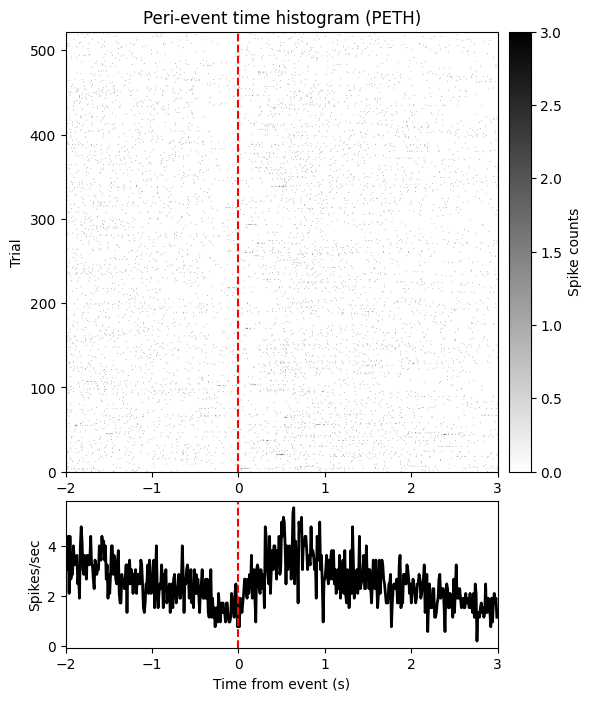

In [13]:
spikes.plot_peth(peth)

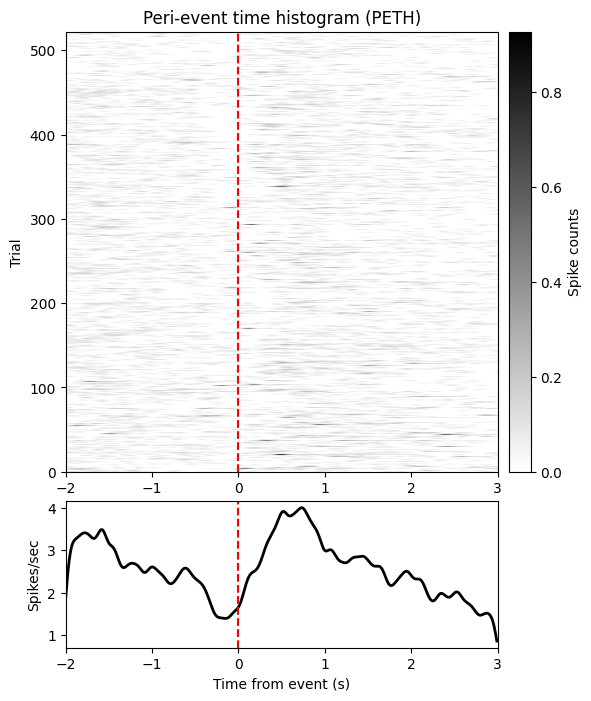

In [14]:
peth_smooth = spikes.compute_peth_smooth(peth, sigma_sec=0.05)
spikes.plot_peth(peth_smooth)

(-1.0, 2.0)

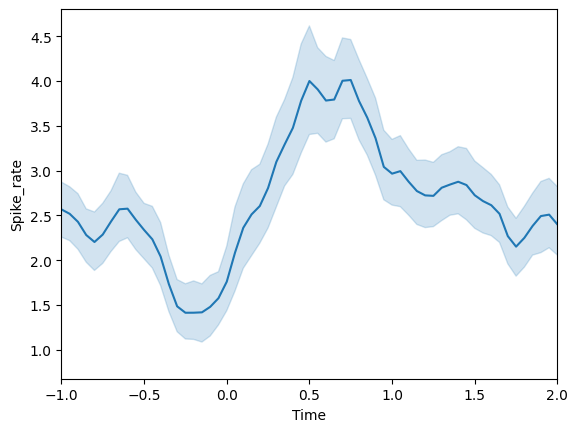

In [15]:
unit_id = unit_ids[100]
event_time = behv_time['choice']
spike_time = sorting.get_unit_spike_train(unit_id=unit_id)/sampling_rate

peth = spikes.compute_peth_array(
    spike_times=spike_time,
    event_times=event_time,
    bin_size=0.05,
    time_window=[-2, 3])

peth_smooth = spikes.compute_peth_smooth(peth, sigma_sec=0.05)
peth_fr = spikes.compute_peth_fr(peth_smooth)

peth_df = spikes.peth_to_longdf(peth_fr)

sns.lineplot(
    data=peth_df, 
    x='Time', 
    y='Spike_rate', 
)
plt.xlim([-1, 2])

In [16]:
trial_target = trials[['Trial', 'Stim', 'Choice', 'Correct']].dropna()
df = peth_df.merge(trial_target, on='Trial', how='left')
df

,Time,Trial,Spike_rate,Stim,Choice,Correct
0,-2.00,1,0.000000,right,right,True
1,-1.95,1,0.000000,right,right,True
2,-1.90,1,0.000000,right,right,True
3,-1.85,1,0.000000,right,right,True
4,-1.80,1,0.000000,right,right,True
...,...,...,...,...,...,...
52195,2.75,522,1.079823,right,right,True
52196,2.80,522,4.839429,right,right,True
52197,2.85,522,7.978869,right,right,True
52198,2.90,522,4.839429,right,right,True


(-1.0, 3.0)

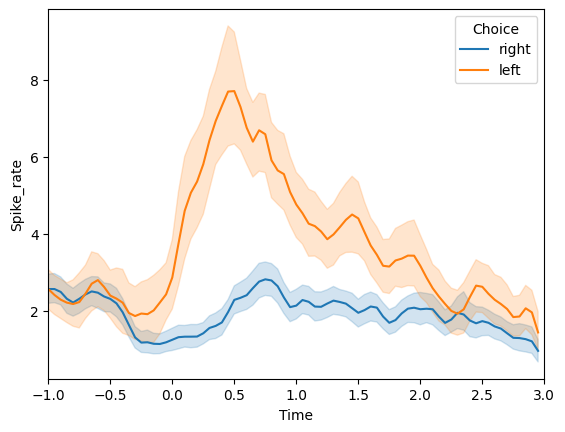

In [17]:
sns.lineplot(
    data=df, 
    x='Time', 
    y='Spike_rate',
    hue='Choice',
)
plt.xlim([-1, 3])

## Z-score


Text(0.5, 1.0, 'Unit 191 - PETH for Ready Event')

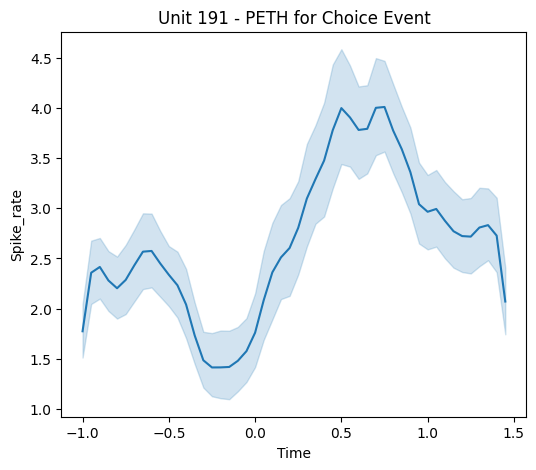

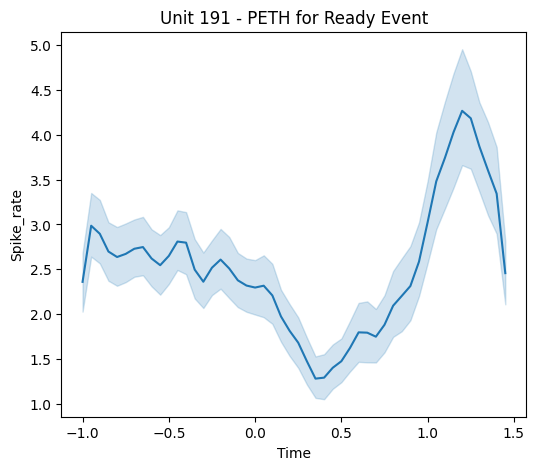

In [18]:
unit_id = unit_ids[100]
spike_time = sorting.get_unit_spike_train(unit_id=unit_id)/sampling_rate


# Compute PETH for 'choice' event
event_time = behv_time['choice']
peth = spikes.compute_peth_array(
spike_times=spike_time,
    event_times=event_time,
    bin_size=0.05,
    time_window=[-1, 1.5])

peth_smooth = spikes.compute_peth_smooth(peth, sigma_sec=0.05)
peth_fr = spikes.compute_peth_fr(peth_smooth)
peth_df = spikes.peth_to_longdf(peth_fr)

plt.figure(figsize=(6, 5))
sns.lineplot(
    data=peth_df, 
    x='Time', 
    y='Spike_rate', 
)
plt.title(f'Unit {unit_id} - PETH for Choice Event')


# Compute PETH for 'ready' event
event_time = behv_time['ready']
peth = spikes.compute_peth_array(
    spike_times=spike_time,
    event_times=event_time,
    bin_size=0.05,
    time_window=[-1, 1.5])

peth_smooth = spikes.compute_peth_smooth(peth, sigma_sec=0.05)
peth_fr = spikes.compute_peth_fr(peth_smooth)
peth_df = spikes.peth_to_longdf(peth_fr)

plt.figure(figsize=(6, 5))
sns.lineplot(
    data=peth_df, 
    x='Time', 
    y='Spike_rate', 
)
plt.title(f'Unit {unit_id} - PETH for Ready Event')

### Clstering


In [19]:
# Compute PETH dict
# spike_time, event_timeなどから、peth_fr, petf_drを計算してまとめる関数
def compute_peth_dict(spike_time, event_time, bin_size=0.05, time_window=[-1, 1.5], sigma_sec=0.05):
    peth = spikes.compute_peth_array(
    spike_times=spike_time,
        event_times=event_time,
        bin_size=bin_size,
        time_window=time_window)

    peth_smooth = spikes.compute_peth_smooth(peth, sigma_sec=sigma_sec)
    peth_fr = spikes.compute_peth_fr(peth_smooth)
    peth_df = spikes.peth_to_longdf(peth_fr)
    
    PETH = {
        'fr': peth_fr,
        'df': peth_df
    }
    
    return PETH

In [20]:
unit_id = unit_ids[100]
spike_time = sorting.get_unit_spike_train(unit_id=unit_id)/sampling_rate

bin_size = 0.05
sigma_sec = 0.05
PETH_ready = compute_peth_dict(spike_time, behv_time['ready'], bin_size=bin_size, time_window=[-0.5, 1.5], sigma_sec=sigma_sec)
PETH_choice = compute_peth_dict(spike_time, behv_time['choice'], bin_size=bin_size, time_window=[-1, 1.5], sigma_sec=sigma_sec)

Baseline average spike rate: 1.8631039360170683
Baseline standard deviation of spike rate: 3.7150554939138347


Text(0, 0.5, 'Z-score of Spike Rate')

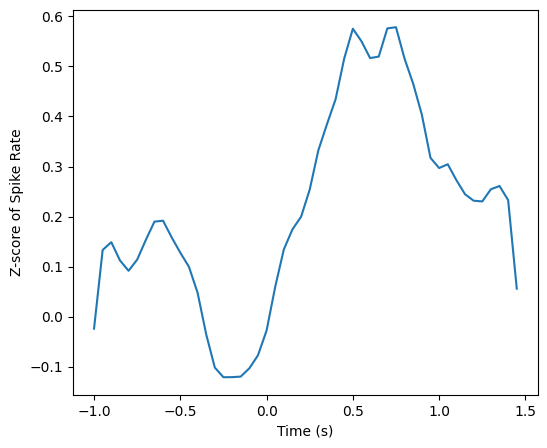

In [21]:
# Compute z-score of spike rate
df = PETH_ready['df']
avg = df.loc[(df['Time']>=0) & (df['Time']<1), 'Spike_rate'].mean()
std = df.loc[(df['Time']>=0) & (df['Time']<1), 'Spike_rate'].std()
base_line = {
    'avg': avg,
    'std': std
}
print('Baseline average spike rate:', avg)
print('Baseline standard deviation of spike rate:', std)

fr = PETH_choice['fr']
bins = fr['bins']
spks = fr['spike_rate']
z_score = (spks - base_line['avg']) / base_line['std']

plt.figure(figsize=(6, 5))
sns.lineplot(
    x=bins[0:-1],
    y=z_score.mean(axis=0),
)
plt.xlabel('Time (s)')
plt.ylabel('Z-score of Spike Rate')

In [22]:
# Function to compute z-score from PETH DataFrame
def compute_base_line(event_time, spike_time, bins_size=0.05, time_window=[0, 1], sigma_sec=0.05, target_time_window=[0, 1]):

    PETH = compute_peth_dict(spike_time, event_time, bins_size, time_window, sigma_sec)
    df = PETH['df']

    df = PETH['df']
    avg = df.loc[(df['Time']>=target_time_window[0]) & (df['Time']<target_time_window[1]), 'Spike_rate'].mean()
    std = df.loc[(df['Time']>=target_time_window[0]) & (df['Time']<target_time_window[1]), 'Spike_rate'].std()
    base_line = {
        'avg': avg,
        'std': std
    }
    
    return base_line


# Function to compute z-score from PETH DataFrame
def compute_z_score(event_time, spike_time, bins_size=0.05, time_window=[-1, 1.5], sigma_sec=0.05, base_line=[0, 1], target_time_window=[0, 1]):

    PETH = compute_peth_dict(spike_time, event_time, bins_size, time_window, sigma_sec)
    fr = PETH['fr']
    bins = fr['bins']

    z_score = (fr['spike_rate'] - base_line['avg']) / base_line['std']
    
    # Filter
    tf = (bins[0:-1]>=target_time_window[0])&(bins[0:-1]<target_time_window[1])
    z_score_target = z_score[:, tf]
    mean_z_score = z_score_target.mean(axis=0)
    
    return mean_z_score

In [23]:
unit_id = unit_ids[100]
spike_time = sorting.get_unit_spike_train(unit_id=unit_id)/sampling_rate

event_time = behv_time['ready']
base_line = compute_base_line(event_time, spike_time, bins_size=0.05, time_window=[-0.5, 1.5], sigma_sec=0.05, target_time_window=[0, 1])

event_time = behv_time['choice']
mean_z_socre = compute_z_score(event_time, spike_time, bins_size=0.05, time_window=[-1, 1.5], sigma_sec=0.05, base_line=base_line, target_time_window=[0, 1])



In [24]:
bins_size = 0.05
sigma_sec=0.05

# Initialize arrays to store z-scores for each unit and event type
col_length = 20  # Number of bins in the PETH
z_score_stim = np.zeros((len(unit_ids), col_length))
z_score_choice = np.zeros((len(unit_ids), col_length))
z_score_outcome = np.zeros((len(unit_ids), col_length))

# Compute z-score for each unit and event type
for i in range(0, len(unit_ids)):
    unit_id = unit_ids[i]
    spike_time = sorting.get_unit_spike_train(unit_id=unit_id)/sampling_rate
    
    event_time = behv_time['ready']
    base_line = compute_base_line(event_time, spike_time, bins_size=bin_size, time_window=[-0.5, 1.5], sigma_sec=sigma_sec, target_time_window=[0, 1])
    
    event_time = behv_time['stim']
    z_score_stim[i, :] = compute_z_score(event_time, spike_time, bins_size=bin_size, time_window=[-1, 1.5], sigma_sec=sigma_sec, base_line=base_line, target_time_window=[0, 1])
    
    event_time = behv_time['choice']
    z_score_choice[i, :] = compute_z_score(event_time, spike_time, bins_size=bin_size, time_window=[-1, 1.5], sigma_sec=sigma_sec, base_line=base_line, target_time_window=[0, 1])
    
    event_time = behv_time['outcome']
    z_score_outcome[i, :] = compute_z_score(event_time, spike_time, bins_size=bin_size, time_window=[-1, 1.5], sigma_sec=sigma_sec, base_line=base_line, target_time_window=[0, 1])
    
    if i % 10 == 0:
        print(f'Unit {i+1}/{len(unit_ids)}')


Unit 1/382
Unit 11/382
Unit 21/382
Unit 31/382
Unit 41/382
Unit 51/382
Unit 61/382
Unit 71/382
Unit 81/382
Unit 91/382
Unit 101/382
Unit 111/382
Unit 121/382
Unit 131/382
Unit 141/382
Unit 151/382
Unit 161/382
Unit 171/382
Unit 181/382
Unit 191/382
Unit 201/382
Unit 211/382
Unit 221/382
Unit 231/382
Unit 241/382
Unit 251/382
Unit 261/382
Unit 271/382
Unit 281/382
Unit 291/382
Unit 301/382
Unit 311/382
Unit 321/382
Unit 331/382
Unit 341/382
Unit 351/382
Unit 361/382
Unit 371/382
Unit 381/382


In [25]:
tunning_vector = np.concat([z_score_stim, z_score_choice, z_score_outcome], axis=1)

In [26]:
from sklearn.decomposition import PCA
import pandas as pd

# Perform PCA with 20 components
pca = PCA(n_components=20)
pca_result = pca.fit_transform(tunning_vector)

# Get the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Compute the cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()

# Create a DataFrame to summarize PCA results
df_pca_info = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'ExplainedVariance': explained_variance_ratio,
    'CumulativeVariance': cumulative_variance
})

# Display the DataFrame
df_pca_info

,PC,ExplainedVariance,CumulativeVariance
0,PC1,0.501541,0.501541
1,PC2,0.216660,0.718201
2,PC3,0.101113,0.819315
3,PC4,0.071269,0.890584
4,PC5,0.039374,0.929958
5,PC6,0.017635,0.947593
6,PC7,0.015561,0.963154
7,PC8,0.007971,0.971124
8,PC9,0.005362,0.976486
9,PC10,0.004509,0.980995


In [27]:
# k-means clustering
from sklearn.cluster import KMeans

# Perform k-means clustering with 3 clusters
kmeans = KMeans(n_clusters=20, random_state=0).fit(pca_result)

# Get cluster labels for each sample
cluster_labels = kmeans.labels_

# Show the labels
df = pd.DataFrame({
    'UnitID': unit_ids,
    'Cluster': cluster_labels
})
df

,UnitID,Cluster
0,4,13
1,5,15
2,8,1
3,11,12
4,13,9
...,...,...
377,674,14
378,677,16
379,682,7
380,694,17


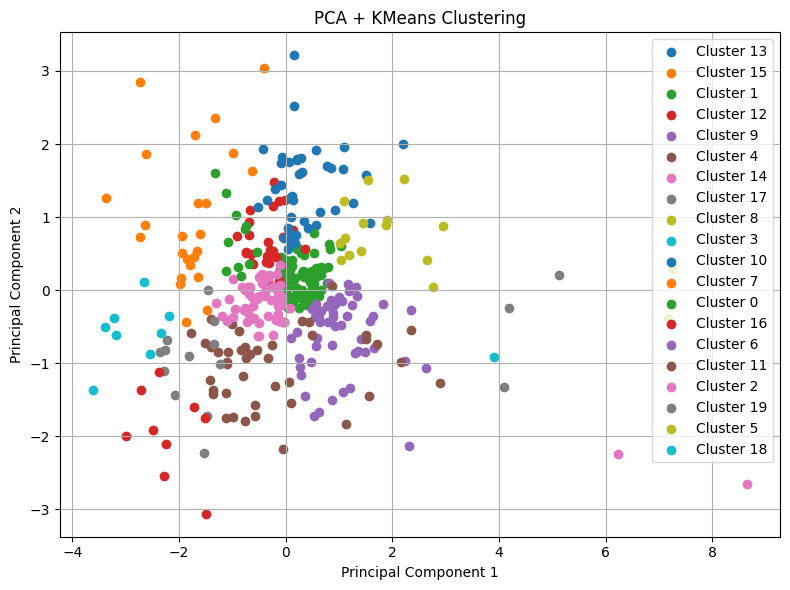

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame from the first 2 PCA components
pca_info = pd.DataFrame(pca_result[:, :2], columns=['PC1', 'PC2'])

# Add cluster labels
pca_info['Cluster'] = kmeans.labels_

# Plot
plt.figure(figsize=(8, 6))
for cluster_id in pca_info['Cluster'].unique():
    cluster_data = pca_info[pca_info['Cluster'] == cluster_id]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster_id}')

plt.title('PCA + KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

   unit_id phase  time     value
0        0  stim   0.0  0.165797
1        1  stim   0.0 -0.000536
2        2  stim   0.0  0.078063
3        3  stim   0.0 -0.001749
4        4  stim   0.0  0.053172


<Axes: xlabel='time', ylabel='value'>

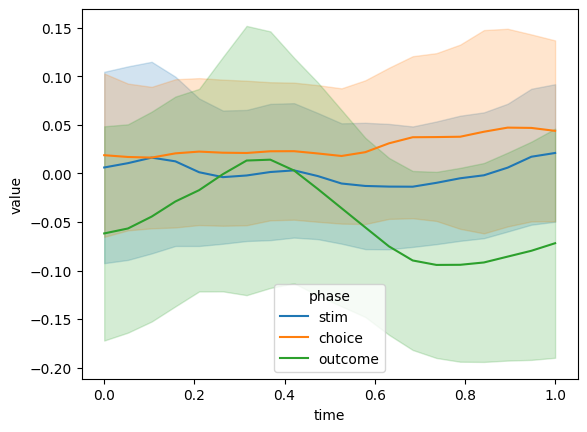

In [29]:
cluster_id = 1
# Get indices of units belonging to this cluster
idx = np.where(cluster_labels == cluster_id)[0]

# Select tuning vectors for those units
cluster_vectors = tunning_vector[idx]

bin_num = 20
time_points = np.linspace(0, 1, bin_num)
phase_dfs = []
phases = ['stim', 'choice', 'outcome']

# Loop through each phase and process the corresponding 20 columns
for i, phase in enumerate(phases):
    start = i * bin_num           # e.g., 0, 20, 40
    end = start + bin_num         # e.g., 20, 40, 60

    # Extract the 20 columns for this phase
    df_part = pd.DataFrame(cluster_vectors[:, start:end])
    df_part['unit_id'] = df_part.index  # Add unit ID column

    # Convert to long format: one row per (unit, time bin)
    df_long = df_part.melt(id_vars='unit_id', var_name='bin', value_name='value')

    # Assign time values to each bin (bin is 0–19 repeated for each unit)
    df_long['time'] = df_long['bin'].astype(int).map(dict(enumerate(time_points)))

    # Add the phase label (stim, button, reward)
    df_long['phase'] = phase

    # Reorder columns for clarity
    df_long = df_long[['unit_id', 'phase', 'time', 'value']]

    # Store for later merging
    phase_dfs.append(df_long)

# Combine all three phases into one DataFrame
df_all_long = pd.concat(phase_dfs, ignore_index=True)

# Preview the final result
print(df_all_long.head())


# 表示
sns.lineplot(
    data=df_all_long, 
    x='time', 
    y='value', 
    hue='phase',
    #style='unit_id',
    estimator=np.mean,
    errorbar='sd',
    #legend=False
)

   unit_id phase  time     value
0        0  stim   0.0  0.098002
1        1  stim   0.0  0.177363
2        2  stim   0.0  0.165797
3        3  stim   0.0 -0.026898
4        4  stim   0.0 -0.334320


C:\Users\Sugimoto\AppData\Local\Temp\ipykernel_46472\4031003196.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


<Axes: xlabel='time', ylabel='value'>

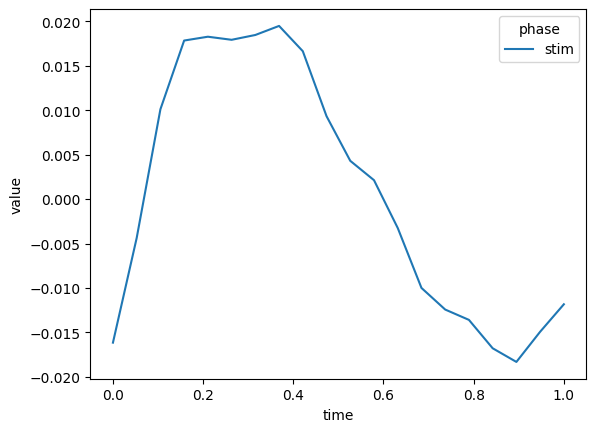

In [30]:
# 0–1秒を20分割した時間軸
time_points = np.linspace(0, 1, 20)

# 最初の20列（stim）
df_stim = pd.DataFrame(tunning_vector[:, :20])
df_stim['unit_id'] = df_stim.index

# 縦長に変換（long-format）
df_long = df_stim.melt(id_vars='unit_id', var_name='bin', value_name='value')

# 時間列を追加（binは0〜19が繰り返されるので、それをtimeに変換）
df_long['time'] = df_long['bin'].astype(int).map(dict(enumerate(time_points)))

# phase列を追加（すべてstim）
df_long['phase'] = 'stim'

# 整理
df_long = df_long[['unit_id', 'phase', 'time', 'value']]

# 表示
print(df_long.head())
# 表示
sns.lineplot(
    data=df_long, 
    x='time', 
    y='value', 
    hue='phase', 
    ci=None
)